In [1]:
%load_ext autoreload
%autoreload 2

import sys

module_dir = '../'

if module_dir not in sys.path:
    sys.path.append(module_dir)

import numpy as np
import matplotlib.pyplot as plt
import sklearn as skl
from models import *
import test_systems_1d as systems_1d
import itertools
from matplotlib.colors import TwoSlopeNorm
from matplotlib.colors import NoNorm
from matplotlib.colors import Normalize
from tqdm import tqdm
import gpjax as gpx
from sklearn.decomposition import PCA
import scipy.io
from scipy.interpolate import griddata

from jax import config
config.update("jax_enable_x64", True)

/Users/tomcowperthwaite/opt/anaconda3/envs/mres2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
x = np.load('../navier_stokes_data/NavierStokes_inputs.npy').transpose((2,1,0)).reshape(40000, 64*64)
y = np.load('../navier_stokes_data/NavierStokes_outputs.npy').transpose((2,1,0)).reshape(40000, 64*64)

x_train = x[int(len(x)/5):, :]
y_train = y[int(len(y)/5):, :]

x_test = x[:int(len(x)/5), :]
y_test = y[:int(len(y)/5), :]

print(x.shape, y.shape)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

x_train = x_train[:1000, :]
y_train = y_train[:1000, :]

x_test = x_test[:1000, :]
y_test = y_test[:1000, :]

(40000, 4096) (40000, 4096)
(32000, 4096) (32000, 4096)
(8000, 4096) (8000, 4096)


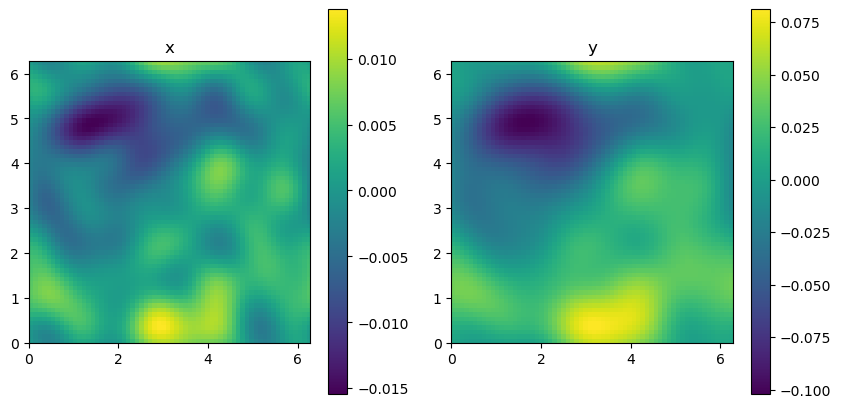

In [3]:
index_to_plot = 12

# print(len(x_train), x_train.shape, x_train[1].shape, y_train.shape)
# print(len(x_test), x_test.shape, x_test[1].shape, y_test.shape)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
im0 = ax[0].imshow(x_train[index_to_plot, :].reshape(64, 64), origin='lower', extent=[0, 2*np.pi, 0, 2*np.pi])
ax[0].set_title("x")
im1 = ax[1].imshow(y_train[index_to_plot, :].reshape(64, 64), origin='lower', extent=[0, 2*np.pi, 0, 2*np.pi])
ax[1].set_title("y")
fig.colorbar(im0, ax=ax[0])
fig.colorbar(im1, ax=ax[1])
plt.show()

In [72]:
import sys
module_dir = '../'
if module_dir not in sys.path:
    sys.path.append(module_dir)
from models import *
import gpjax as gpx

class full_model():
    def __init__(self, n, m, ARD, multiinput, standardise):
        self.n = n
        self.m = m
        self.ARD = ARD
        self.multiinput = multiinput
        self.standardise = standardise

    def fit(self, x_train, y_train, n_samples = None):

        if self.ARD:
            ls = jnp.full(self.n, 2, dtype=jnp.float64)
            var = jnp.full(self.n, 2, dtype=jnp.float64)
        else:
            ls = jnp.full((1), 2, dtype=jnp.float64)
            var = jnp.full((1), 2, dtype=jnp.float64)

        GP_params = {"kernel": gpx.kernels.RBF(lengthscale = ls, variance = jnp.full((1), 1, dtype=jnp.float64)), 'mean_function': gpx.mean_functions.Zero(), 'multiinput': self.multiinput}

        self.x_train = x_train
        self.y_train = y_train

        if self.m is None:
            self.m = self.y_train.shape[-1]

        self.x_pca = PCA(n_components = self.n)
        self.y_pca = PCA(n_components = self.m)
        self.x_train_pca = self.x_pca.fit_transform(self.x_train)
        print('does x pca')
        self.y_train_pca = self.y_pca.fit_transform(self.y_train)
        print('does y pca')

        self.model_list = []

        if n_samples is not None:
            train_samples_pca = np.zeros((x_train.shape[0], self.m, n_samples))
            train_samples = np.zeros((self.y_train.shape[0], self.y_train.shape[1], n_samples))

        if self.standardise:
            self.x_train_pca_stand = (self.x_train_pca - self.x_train_pca.mean(axis = 0))/self.x_train_pca.std(axis = 0)
            self.y_train_pca_stand = (self.y_train_pca - self.y_train_pca.mean(axis = 0))/self.y_train_pca.std(axis = 0)

            if self.multiinput:
                for i in tqdm(range(self.y_train_pca_stand.shape[-1])):
                    local_gp = GP_regressor(GP_params=GP_params)
                    local_gp.fit(self.x_train_pca_stand, self.y_train_pca_stand[:, i])
                    print(local_gp.kernel.lengthscale)
                    print(local_gp.kernel.variance)
                    self.model_list.append(local_gp)
                    if n_samples is not None:
                        train_samples_pca[:, i, :] = local_gp.sample_posterior(self.x_train_pca_stand, n_samples = n_samples)
            
            else:
                for i in tqdm(range(self.y_train_pca_stand.shape[-1])):
                    local_gp = GP_regressor(GP_params=GP_params)
                    local_gp.fit(self.x_train_pca_stand[:, i].reshape(-1, 1), self.y_train_pca_stand[:, i])
                    self.model_list.append(local_gp)
                    if n_samples is not None:
                        train_samples_pca[:, i, :] = local_gp.sample_posterior(self.x_train_pca_stand[:, i].reshape(-1, 1), n_samples = n_samples)

        else:
            if self.multiinput:
                for i in tqdm(range(self.y_train_pca.shape[-1])):
                    local_gp = GP_regressor(GP_params=GP_params)
                    local_gp.fit(self.x_train_pca, self.y_train_pca[:, i])
                    self.model_list.append(local_gp)
                    if n_samples is not None:
                        train_samples_pca[:, i, :] = local_gp.sample_posterior(self.x_train_pca, n_samples = n_samples)
            
            else:
                for i in tqdm(range(self.y_train_pca.shape[-1])):
                    local_gp = GP_regressor(GP_params=GP_params)
                    local_gp.fit(self.x_train_pca[:, i].reshape(-1, 1), self.y_train_pca[:, i])
                    self.model_list.append(local_gp)
                    if n_samples is not None:
                        train_samples_pca[:, i, :] = local_gp.sample_posterior(self.x_train_pca[:, i].reshape(-1, 1), n_samples = n_samples)

        if n_samples is not None:
            for i in range(n_samples):
                train_samples_pca_i = train_samples_pca[:, :, i]
                train_samples_i = self.y_pca.inverse_transform(train_samples_pca_i)
                train_samples[:, :, i] = train_samples_i
            return train_samples
    
    def predict(self, x_test, n_samples = None):

        self.x_test = x_test

        self.x_test_pca = self.x_pca.transform(x_test)

        if n_samples is not None:
            test_samples_pca = np.zeros((x_test.shape[0], self.m, n_samples))
            test_samples = np.zeros((self.x_test.shape[0], self.y_train.shape[1], n_samples))
        
        if self.standardise:
            y_pred_pca_stand = []
            self.x_test_pca_stand = (self.x_test_pca - self.x_train_pca.mean(axis = 0))/self.x_train_pca.std(axis = 0)
            if self.multiinput:
                for i in tqdm(range(self.m)):
                    local_gp = self.model_list[i]
                    y_pred_pca_stand.append(local_gp.predict(self.x_test_pca_stand))
                    if n_samples is not None:
                        test_samples_pca[:, i, :] = local_gp.sample_posterior(self.x_test_pca_stand, n_samples = n_samples)
                        test_samples_pca[:, i, :] = (test_samples_pca[:, i, :] * self.y_train_pca.std(axis = 0)[i]) + self.y_train_pca.mean(axis = 0)[i]
            
            else:
                for i in tqdm(range(self.m)):
                    local_gp = self.model_list[i]
                    y_pred_pca_stand.append(local_gp.predict(self.x_test_pca_stand[:, i].reshape(-1, 1)))
                    if n_samples is not None:
                        test_samples_pca[:, i, :] = local_gp.sample_posterior(self.x_test_pca_stand[:, i].reshape(-1, 1), n_samples = n_samples)
                        test_samples_pca[:, i, :] = (test_samples_pca[:, i, :] * self.y_train_pca.std(axis = 0)[i]) + self.y_train_pca.mean(axis = 0)[i]
            
            y_pred_pca_stand = np.stack(y_pred_pca_stand).T
            self.y_pred_pca = (y_pred_pca_stand * self.y_train_pca.std(axis = 0)) + self.y_train_pca.mean(axis = 0)
        
        else:
            self.y_pred_pca = []
            if self.multiinput:
                for i in tqdm(range(self.m)):
                    local_gp = self.model_list[i]
                    self.y_pred_pca.append(local_gp.predict(self.x_test_pca))
                    if n_samples is not None:
                        test_samples_pca[:, i, :] = local_gp.sample_posterior(self.x_test_pca, n_samples = n_samples)
            
            else:
                for i in tqdm(range(self.m)):
                    local_gp = self.model_list[i]
                    self.y_pred_pca.append(local_gp.predict(self.x_test_pca[:, i].reshape(-1, 1)))
                    if n_samples is not None:
                        test_samples_pca[:, i, :] = local_gp.sample_posterior(self.x_test_pca[:, i].reshape(-1, 1), n_samples = n_samples)
            
            self.y_pred_pca = np.stack(self.y_pred_pca).T
        
        y_pred = self.y_pca.inverse_transform(self.y_pred_pca)

        if n_samples is not None:
            for i in range(n_samples):
                test_samples_pca_i = test_samples_pca[:, :, i]
                test_samples_i = self.y_pca.inverse_transform(test_samples_pca_i)
                test_samples[:, :, i] = test_samples_i
            return y_pred[:, 0, :], test_samples
        else:
            return y_pred[:, 0, :]

In [73]:
# determine n
# x_pca = PCA(n_components=x_train.shape[-1])
# x_train_pca = x_pca.fit_transform(x_train)

# plt.plot(np.cumsum(x_pca.explained_variance_ratio_))
# plt.show()

# n = np.where(np.cumsum(x_pca.explained_variance_ratio_) > 0.95)[0][0]

# # determine m
# y_pca = PCA(n_components=y_train.shape[-1])
# y_train_pca = y_pca.fit_transform(y_train)

# plt.plot(np.cumsum(y_pca.explained_variance_ratio_))
# plt.show()

# m = np.where(np.cumsum(y_pca.explained_variance_ratio_) > 0.99)[0][0]

# print(n, m)

# Train

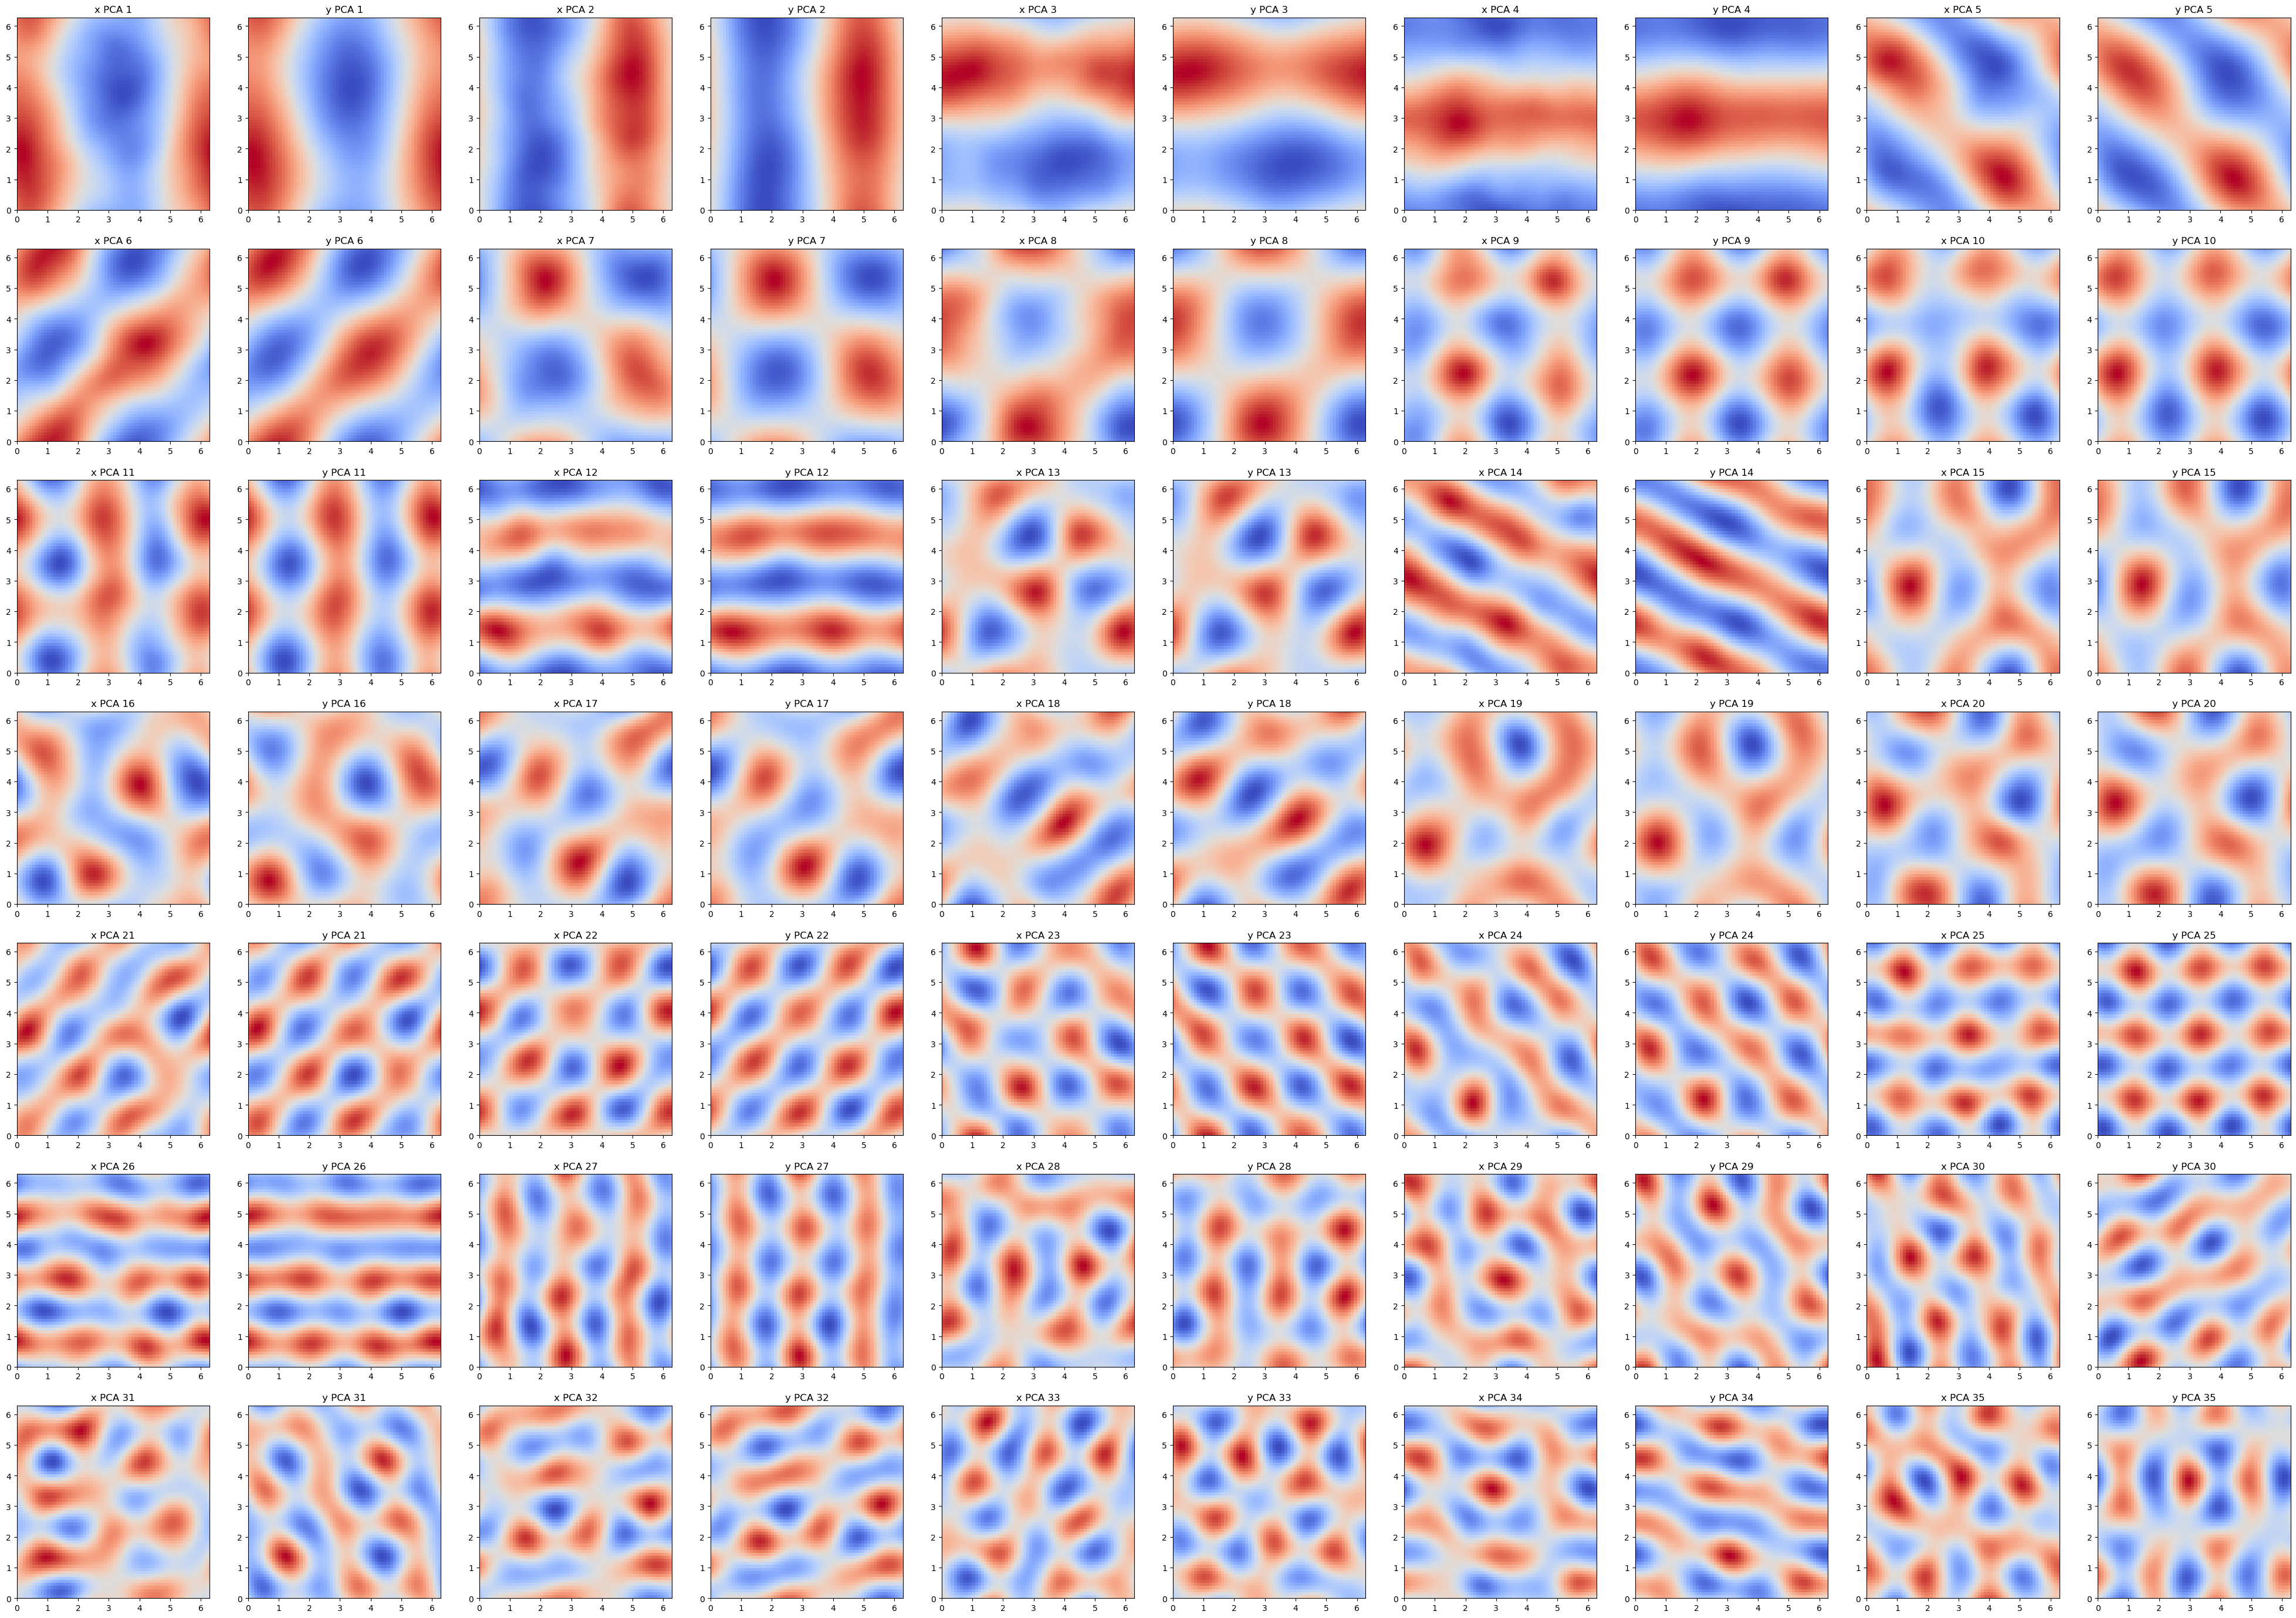

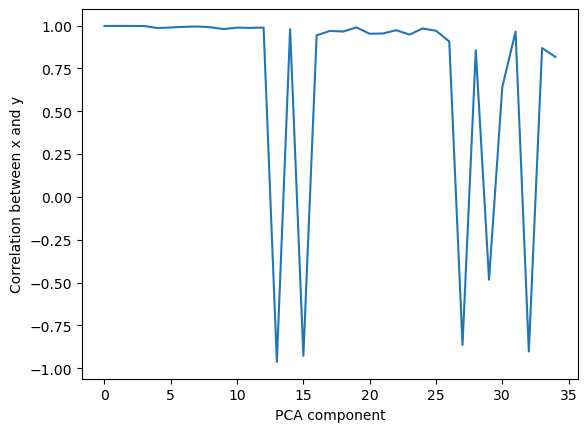

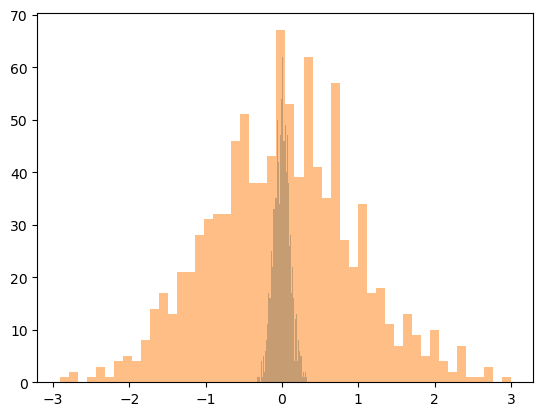

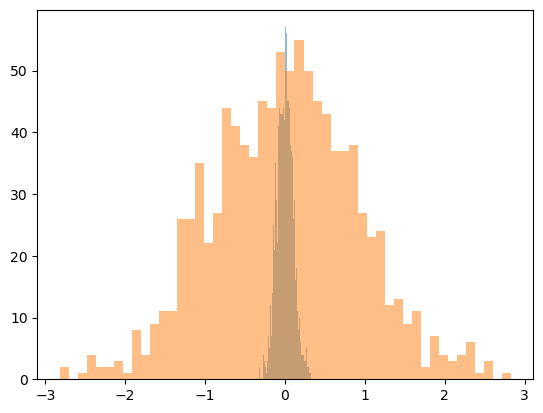

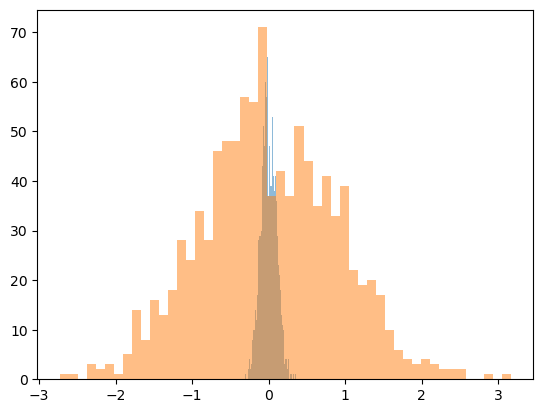

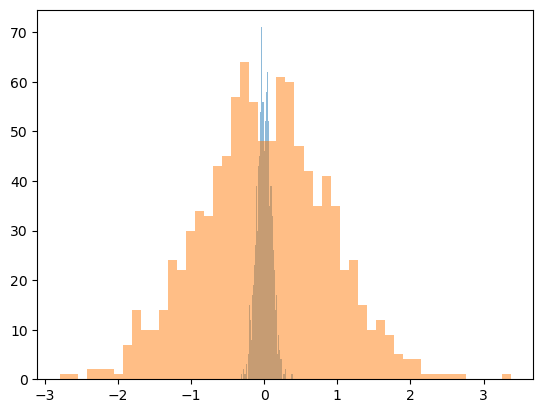

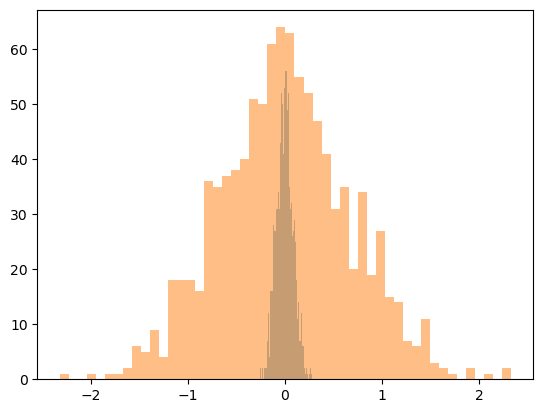

standardising


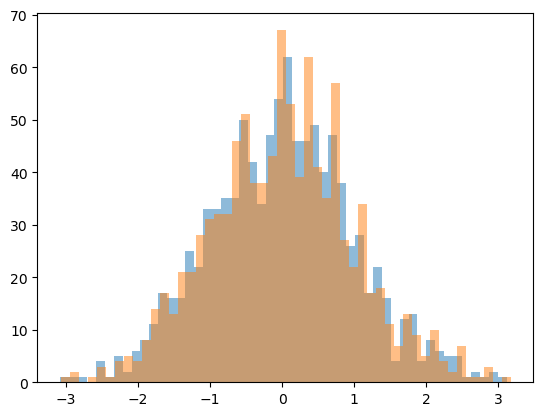

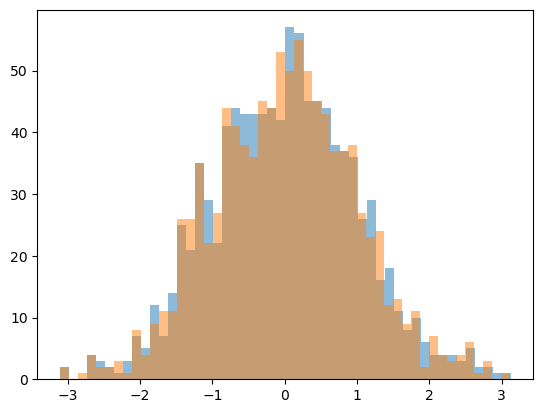

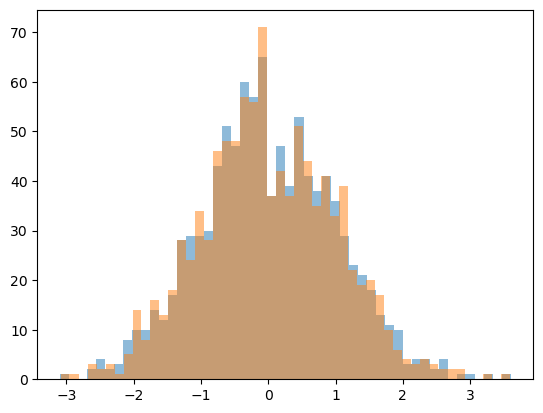

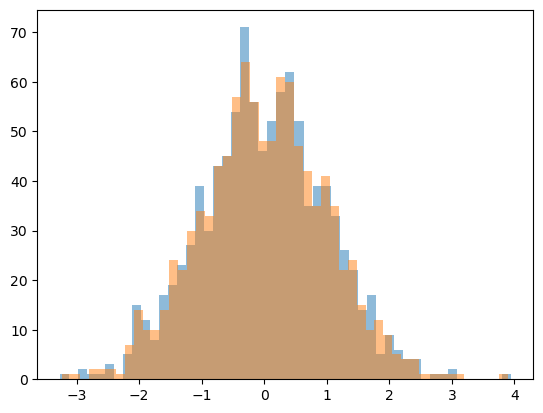

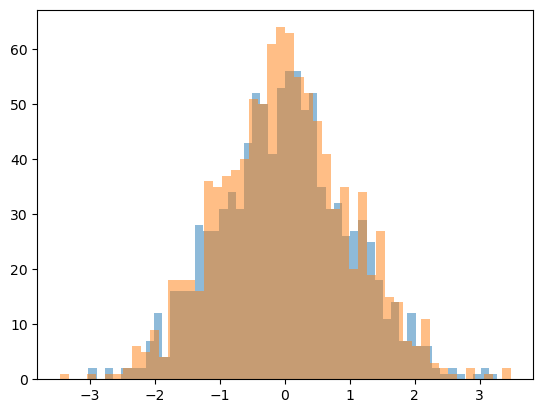

In [102]:
x_train_pca = PCA(n_components=45).fit(x_train)
y_train_pca = PCA(n_components=35).fit(y_train)

fig, ax = plt.subplots(7, 10, figsize=(50, 35))
ax = ax.flatten()

for i in range(0, 70, 2):
    ax[i].imshow(x_train_pca.components_[int(i/2), :].reshape(64, 64), origin='lower', extent=[0, 2*np.pi, 0, 2*np.pi], cmap='coolwarm')
    ax[i].set_title(f"x PCA {int(i/2)+1}")
    ax[i+1].imshow(y_train_pca.components_[int(i/2), :].reshape(64, 64), origin='lower', extent=[0, 2*np.pi, 0, 2*np.pi], cmap='coolwarm')
    ax[i+1].set_title(f"y PCA {int(i/2)+1}")
plt.show()

corr_list = []
fig, ax = plt.subplots(7, 5, figsize=(25, 35))
ax = ax.flatten()
for i in range(0, 35):
    ax[i].plot(x_train_pca.components_[i, :], y_train_pca.components_[i, :], marker='o', linestyle='', alpha = 0.2)
    ax[i].set_xlabel(f"PCA {i+1} x")
    ax[i].set_ylabel(f"PCA {i+1} y")
    ax[i].set_title(f"PCA {i+1} x-y comparison")
    corr_list.append(np.corrcoef(x_train_pca.components_[i, :], y_train_pca.components_[i, :])[0, 1])
plt.show()

plt.figure()
plt.plot(corr_list)
plt.xlabel('PCA component')
plt.ylabel('Correlation between x and y')
plt.show()

x_train_pca = x_train_pca.transform(x_train)
y_train_pca = y_train_pca.transform(y_train)

for i in range(5):
    plt.figure()
    plt.hist(x_train_pca[:, i], bins=50, label = f'x_train_pca {i+1}', alpha=0.5)
    plt.hist(y_train_pca[:, i], bins=50, label = f'y_train_pca {i+1}', alpha=0.5)
    plt.show()

print('standardising')

for i in range(5):
    x_train_pca_stand_i = (x_train_pca[:, i] - x_train_pca[:, i].mean(axis = 0))/x_train_pca[:, i].std(axis = 0)
    y_train_pca_stand_i = (y_train_pca[:, i] - y_train_pca[:, i].mean(axis = 0))/y_train_pca[:, i].std(axis = 0)
    plt.figure()
    plt.hist(x_train_pca_stand_i, bins=50, label = f'x_train_pca_stand {i+1}', alpha=0.5)
    plt.hist(y_train_pca_stand_i, bins=50, label = f'y_train_pca_stand {i+1}', alpha=0.5)
    plt.show()



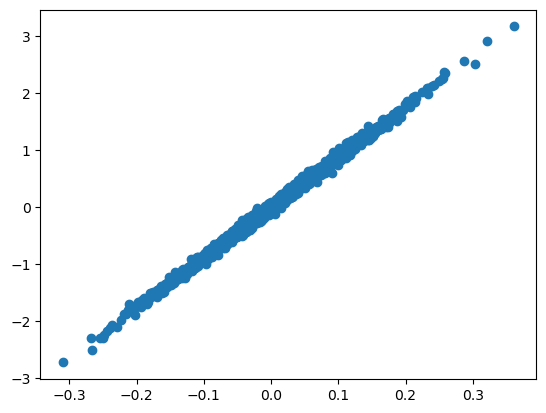

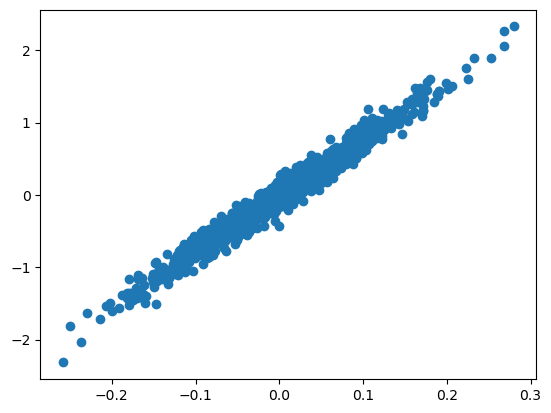

In [75]:
for i in range(5):
    plt.figure()
    plt.plot(x_train_pca[:, i], y_train_pca[:, i], 'o')
    plt.show()

In [103]:
## Train

n, m = 45, 45 # n, m = 45, 35 for variance explained 0.95, 0.99

model = full_model(n = n, m = m, ARD = False, multiinput = True, standardise = True)
train_samples = model.fit(x_train, y_train)

does x pca
does y pca


  0%|          | 0/45 [00:00<?, ?it/s]

[1.]
float64


  2%|▏         | 1/45 [00:49<36:26, 49.70s/it]

Optimization terminated successfully.
         Current function value: -2281.930303
         Iterations: 54
         Function evaluations: 60
         Gradient evaluations: 60
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([61.84149972], dtype=float64), variance=Array([10.], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.00166438], dtype=float64))
[2.]
[1.]
[1.]
float64


/Users/tomcowperthwaite/opt/anaconda3/envs/mres2/lib/python3.10/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
  4%|▍         | 2/45 [02:07<47:15, 65.94s/it]

         Current function value: -2254.713182
         Iterations: 35
         Function evaluations: 137
         Gradient evaluations: 122
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([60.72676543], dtype=float64), variance=Array([9.99999878], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.00129558], dtype=float64))
[2.]
[1.]
[1.]
float64


/Users/tomcowperthwaite/opt/anaconda3/envs/mres2/lib/python3.10/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
  7%|▋         | 3/45 [03:35<53:21, 76.22s/it]

         Current function value: -2195.893543
         Iterations: 50
         Function evaluations: 151
         Gradient evaluations: 139
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([59.73067911], dtype=float64), variance=Array([10.], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.0033675], dtype=float64))
[2.]
[1.]
[1.]
float64


  9%|▉         | 4/45 [04:28<45:43, 66.91s/it]

Optimization terminated successfully.
         Current function value: -2168.552241
         Iterations: 53
         Function evaluations: 67
         Gradient evaluations: 65
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([58.54668038], dtype=float64), variance=Array([10.], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.00298266], dtype=float64))
[2.]
[1.]
[1.]
float64


/Users/tomcowperthwaite/opt/anaconda3/envs/mres2/lib/python3.10/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
 11%|█         | 5/45 [05:17<40:23, 60.59s/it]

         Current function value: -2104.742337
         Iterations: 27
         Function evaluations: 84
         Gradient evaluations: 75
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([56.2928804], dtype=float64), variance=Array([9.99999463], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.00290633], dtype=float64))
[2.]
[1.]
[1.]
float64


/Users/tomcowperthwaite/opt/anaconda3/envs/mres2/lib/python3.10/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
 13%|█▎        | 6/45 [06:18<39:23, 60.61s/it]

         Current function value: -2093.858746
         Iterations: 49
         Function evaluations: 96
         Gradient evaluations: 84
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([56.62980631], dtype=float64), variance=Array([10.], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.00410936], dtype=float64))
[2.]
[1.]
[1.]
float64


/Users/tomcowperthwaite/opt/anaconda3/envs/mres2/lib/python3.10/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
 16%|█▌        | 7/45 [07:00<34:41, 54.76s/it]

         Current function value: -2094.664429
         Iterations: 26
         Function evaluations: 76
         Gradient evaluations: 66
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([55.82753151], dtype=float64), variance=Array([9.99999701], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.00282685], dtype=float64))
[2.]
[1.]
[1.]
float64


/Users/tomcowperthwaite/opt/anaconda3/envs/mres2/lib/python3.10/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
 18%|█▊        | 8/45 [08:01<34:52, 56.54s/it]

         Current function value: -2024.718371
         Iterations: 49
         Function evaluations: 87
         Gradient evaluations: 77
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([54.62549948], dtype=float64), variance=Array([9.99999999], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.00449412], dtype=float64))
[2.]
[1.]
[1.]
float64


 20%|██        | 9/45 [08:56<33:42, 56.18s/it]

Optimization terminated successfully.
         Current function value: -1301.406488
         Iterations: 50
         Function evaluations: 77
         Gradient evaluations: 77
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([36.24682977], dtype=float64), variance=Array([10.], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.00512289], dtype=float64))
[2.]
[1.]
[1.]
float64


 22%|██▏       | 10/45 [09:52<32:45, 56.17s/it]

Optimization terminated successfully.
         Current function value: -1296.408749
         Iterations: 53
         Function evaluations: 75
         Gradient evaluations: 75
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([36.02488156], dtype=float64), variance=Array([10.], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.00393086], dtype=float64))
[2.]
[1.]
[1.]
float64


 24%|██▍       | 11/45 [10:33<29:07, 51.40s/it]

Optimization terminated successfully.
         Current function value: -1280.292018
         Iterations: 40
         Function evaluations: 60
         Gradient evaluations: 60
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([36.4099296], dtype=float64), variance=Array([10.], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.0093551], dtype=float64))
[2.]
[1.]
[1.]
float64


 27%|██▋       | 12/45 [11:15<26:43, 48.58s/it]

Optimization terminated successfully.
         Current function value: -1213.603937
         Iterations: 53
         Function evaluations: 59
         Gradient evaluations: 59
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([35.21454218], dtype=float64), variance=Array([10.], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.01051359], dtype=float64))
[2.]
[1.]
[1.]
float64


 29%|██▉       | 13/45 [11:36<21:28, 40.26s/it]

Optimization terminated successfully.
         Current function value: -1083.350097
         Iterations: 24
         Function evaluations: 30
         Gradient evaluations: 30
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([32.31066447], dtype=float64), variance=Array([10.], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.00647673], dtype=float64))
[2.]
[1.]
[1.]
float64


 31%|███       | 14/45 [12:27<22:25, 43.40s/it]

Optimization terminated successfully.
         Current function value: -1038.613751
         Iterations: 53
         Function evaluations: 80
         Gradient evaluations: 80
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([31.80327162], dtype=float64), variance=Array([10.], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.00918795], dtype=float64))
[2.]
[1.]
[1.]
float64


 33%|███▎      | 15/45 [12:50<18:40, 37.34s/it]

Optimization terminated successfully.
         Current function value: -999.752010
         Iterations: 25
         Function evaluations: 31
         Gradient evaluations: 31
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([30.83182166], dtype=float64), variance=Array([9.99999891], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.00362629], dtype=float64))
[2.]
[1.]
[1.]
float64


 36%|███▌      | 16/45 [13:46<20:48, 43.05s/it]

Optimization terminated successfully.
         Current function value: -1012.729764
         Iterations: 61
         Function evaluations: 91
         Gradient evaluations: 90
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([31.45657759], dtype=float64), variance=Array([10.], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.01030372], dtype=float64))
[2.]
[1.]
[1.]
float64


/Users/tomcowperthwaite/opt/anaconda3/envs/mres2/lib/python3.10/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
 38%|███▊      | 17/45 [15:14<26:22, 56.53s/it]

         Current function value: -1019.316642
         Iterations: 40
         Function evaluations: 200
         Gradient evaluations: 186
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([31.06617535], dtype=float64), variance=Array([9.9999908], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.00100693], dtype=float64))
[2.]
[1.]
[1.]
float64


 40%|████      | 18/45 [15:43<21:37, 48.07s/it]

Optimization terminated successfully.
         Current function value: -957.310587
         Iterations: 35
         Function evaluations: 41
         Gradient evaluations: 41
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([30.16152055], dtype=float64), variance=Array([9.99999998], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.00100009], dtype=float64))
[2.]
[1.]
[1.]
float64


 42%|████▏     | 19/45 [16:37<21:43, 50.12s/it]

Optimization terminated successfully.
         Current function value: -963.092249
         Iterations: 55
         Function evaluations: 93
         Gradient evaluations: 92
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([30.43581998], dtype=float64), variance=Array([10.], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.00805907], dtype=float64))
[2.]
[1.]
[1.]
float64


 44%|████▍     | 20/45 [17:27<20:50, 50.04s/it]

Optimization terminated successfully.
         Current function value: -922.472343
         Iterations: 54
         Function evaluations: 80
         Gradient evaluations: 80
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([30.02390837], dtype=float64), variance=Array([10.], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.0115665], dtype=float64))
[2.]
[1.]
[1.]
float64


/Users/tomcowperthwaite/opt/anaconda3/envs/mres2/lib/python3.10/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
 47%|████▋     | 21/45 [18:15<19:41, 49.23s/it]

         Current function value: -606.815026
         Iterations: 35
         Function evaluations: 94
         Gradient evaluations: 85
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([25.11759099], dtype=float64), variance=Array([9.99972074], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.00101213], dtype=float64))
[2.]
[1.]
[1.]
float64


 49%|████▉     | 22/45 [19:08<19:18, 50.36s/it]

Optimization terminated successfully.
         Current function value: -585.142861
         Iterations: 58
         Function evaluations: 89
         Gradient evaluations: 89
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([25.4591969], dtype=float64), variance=Array([10.], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.02166321], dtype=float64))
[2.]
[1.]
[1.]
float64


/Users/tomcowperthwaite/opt/anaconda3/envs/mres2/lib/python3.10/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
 51%|█████     | 23/45 [20:09<19:37, 53.55s/it]

         Current function value: -540.923858
         Iterations: 46
         Function evaluations: 124
         Gradient evaluations: 112
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([24.86393894], dtype=float64), variance=Array([10.], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.02223115], dtype=float64))
[2.]
[1.]
[1.]
float64


 53%|█████▎    | 24/45 [21:08<19:18, 55.15s/it]

Optimization terminated successfully.
         Current function value: -517.346687
         Iterations: 63
         Function evaluations: 98
         Gradient evaluations: 98
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([24.45736742], dtype=float64), variance=Array([10.], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.0208773], dtype=float64))
[2.]
[1.]
[1.]
float64


/Users/tomcowperthwaite/opt/anaconda3/envs/mres2/lib/python3.10/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
 56%|█████▌    | 25/45 [22:38<21:56, 65.81s/it]

         Current function value: -711.807704
         Iterations: 61
         Function evaluations: 182
         Gradient evaluations: 167
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([28.14463851], dtype=float64), variance=Array([10.], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.03103403], dtype=float64))
[2.]
[1.]
[1.]
float64


 58%|█████▊    | 26/45 [23:14<17:57, 56.71s/it]

Optimization terminated successfully.
         Current function value: -633.443777
         Iterations: 44
         Function evaluations: 51
         Gradient evaluations: 51
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([27.09272094], dtype=float64), variance=Array([9.99999985], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.03440573], dtype=float64))
[2.]
[1.]
[1.]
float64


/Users/tomcowperthwaite/opt/anaconda3/envs/mres2/lib/python3.10/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
 60%|██████    | 27/45 [24:13<17:15, 57.55s/it]

         Current function value: -649.374665
         Iterations: 52
         Function evaluations: 108
         Gradient evaluations: 98
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([27.00647192], dtype=float64), variance=Array([10.], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.03115557], dtype=float64))
[2.]
[1.]
[1.]
float64


/Users/tomcowperthwaite/opt/anaconda3/envs/mres2/lib/python3.10/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
 62%|██████▏   | 28/45 [25:07<15:58, 56.39s/it]

         Current function value: -562.638743
         Iterations: 52
         Function evaluations: 92
         Gradient evaluations: 81
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([26.19735427], dtype=float64), variance=Array([10.], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.03823838], dtype=float64))
[2.]
[1.]
[1.]
float64


/Users/tomcowperthwaite/opt/anaconda3/envs/mres2/lib/python3.10/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
 64%|██████▍   | 29/45 [26:14<15:55, 59.70s/it]

         Current function value: -524.099066
         Iterations: 61
         Function evaluations: 121
         Gradient evaluations: 112
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([25.05566809], dtype=float64), variance=Array([10.], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.03113241], dtype=float64))
[2.]
[1.]
[1.]
float64


/Users/tomcowperthwaite/opt/anaconda3/envs/mres2/lib/python3.10/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
 67%|██████▋   | 30/45 [27:19<15:19, 61.28s/it]

         Current function value: -495.952886
         Iterations: 58
         Function evaluations: 113
         Gradient evaluations: 101
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([24.82124349], dtype=float64), variance=Array([10.], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.03417176], dtype=float64))
[2.]
[1.]
[1.]
float64


/Users/tomcowperthwaite/opt/anaconda3/envs/mres2/lib/python3.10/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
 69%|██████▉   | 31/45 [28:21<14:18, 61.34s/it]

         Current function value: -525.485644
         Iterations: 51
         Function evaluations: 115
         Gradient evaluations: 105
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([25.63066974], dtype=float64), variance=Array([10.], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.03936334], dtype=float64))
[2.]
[1.]
[1.]
float64


 71%|███████   | 32/45 [28:59<11:48, 54.48s/it]

Optimization terminated successfully.
         Current function value: -465.869028
         Iterations: 47
         Function evaluations: 56
         Gradient evaluations: 56
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([24.63785533], dtype=float64), variance=Array([9.99999924], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.03866542], dtype=float64))
[2.]
[1.]
[1.]
float64


 73%|███████▎  | 33/45 [29:43<10:15, 51.31s/it]

Optimization terminated successfully.
         Current function value: -440.271574
         Iterations: 55
         Function evaluations: 62
         Gradient evaluations: 62
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([24.61741545], dtype=float64), variance=Array([10.], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.04428127], dtype=float64))
[2.]
[1.]
[1.]
float64


 76%|███████▌  | 34/45 [30:18<08:28, 46.26s/it]

Optimization terminated successfully.
         Current function value: -393.343712
         Iterations: 42
         Function evaluations: 48
         Gradient evaluations: 48
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([24.60497847], dtype=float64), variance=Array([9.99999926], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.05495824], dtype=float64))
[2.]
[1.]
[1.]
float64


 78%|███████▊  | 35/45 [30:58<07:24, 44.42s/it]

Optimization terminated successfully.
         Current function value: -384.081306
         Iterations: 49
         Function evaluations: 58
         Gradient evaluations: 58
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([24.05683634], dtype=float64), variance=Array([10.], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.0487808], dtype=float64))
[2.]
[1.]
[1.]
float64


 80%|████████  | 36/45 [31:42<06:39, 44.34s/it]

Optimization terminated successfully.
         Current function value: -387.158472
         Iterations: 54
         Function evaluations: 64
         Gradient evaluations: 64
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([23.88760001], dtype=float64), variance=Array([10.], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.04566109], dtype=float64))
[2.]
[1.]
[1.]
float64


 82%|████████▏ | 37/45 [32:16<05:29, 41.25s/it]

Optimization terminated successfully.
         Current function value: -143.915864
         Iterations: 42
         Function evaluations: 48
         Gradient evaluations: 48
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([22.74174913], dtype=float64), variance=Array([9.99999971], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.09127828], dtype=float64))
[2.]
[1.]
[1.]
float64


 84%|████████▍ | 38/45 [32:49<04:32, 38.88s/it]

Optimization terminated successfully.
         Current function value: -266.146811
         Iterations: 41
         Function evaluations: 48
         Gradient evaluations: 48
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([23.40532452], dtype=float64), variance=Array([9.99999952], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.06887069], dtype=float64))
[2.]
[1.]
[1.]
float64


 87%|████████▋ | 39/45 [33:22<03:43, 37.17s/it]

Optimization terminated successfully.
         Current function value: -124.317938
         Iterations: 42
         Function evaluations: 46
         Gradient evaluations: 46
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([23.09208094], dtype=float64), variance=Array([9.99999901], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.10190183], dtype=float64))
[2.]
[1.]
[1.]
float64


 89%|████████▉ | 40/45 [34:01<03:07, 37.52s/it]

Optimization terminated successfully.
         Current function value: -57.307229
         Iterations: 48
         Function evaluations: 54
         Gradient evaluations: 54
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([21.61895465], dtype=float64), variance=Array([9.99999972], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.09845352], dtype=float64))
[2.]
[1.]
[1.]
float64


 91%|█████████ | 41/45 [34:37<02:28, 37.22s/it]

Optimization terminated successfully.
         Current function value: -128.678356
         Iterations: 45
         Function evaluations: 52
         Gradient evaluations: 52
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([22.36500052], dtype=float64), variance=Array([9.99999934], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.08983148], dtype=float64))
[2.]
[1.]
[1.]
float64


 93%|█████████▎| 42/45 [35:10<01:47, 35.96s/it]

Optimization terminated successfully.
         Current function value: -54.305879
         Iterations: 40
         Function evaluations: 46
         Gradient evaluations: 46
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([22.39213891], dtype=float64), variance=Array([9.99999958], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.11120342], dtype=float64))
[2.]
[1.]
[1.]
float64


 96%|█████████▌| 43/45 [35:45<01:11, 35.53s/it]

Optimization terminated successfully.
         Current function value: 31.695280
         Iterations: 42
         Function evaluations: 49
         Gradient evaluations: 49
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([22.6788497], dtype=float64), variance=Array([9.99999951], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.14076907], dtype=float64))
[2.]
[1.]
[1.]
float64


 98%|█████████▊| 44/45 [36:14<00:33, 33.70s/it]

Optimization terminated successfully.
         Current function value: 12.380814
         Iterations: 35
         Function evaluations: 41
         Gradient evaluations: 41
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([21.95388792], dtype=float64), variance=Array([9.72882802], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.12782456], dtype=float64))
[2.]
[1.]
[1.]
float64


100%|██████████| 45/45 [36:46<00:00, 49.02s/it]

Optimization terminated successfully.
         Current function value: -12.839406
         Iterations: 39
         Function evaluations: 44
         Gradient evaluations: 44
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([26.59300295], dtype=float64), variance=Array([9.99999958], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.16334457], dtype=float64))
[2.]
[1.]


In [104]:
n_samples = 6

y_pred_train, train_samples = model.predict(x_train, n_samples = n_samples)

print(train_samples.shape)

relative_L2 = np.linalg.norm(y_pred_train - y_train, axis = -1)/np.linalg.norm(y_train, axis = -1)

print(f'median relative L2 (train data): {np.median(relative_L2)}')
print(f'mean relative L2 (train data): {np.mean(relative_L2)}')

100%|██████████| 45/45 [01:30<00:00,  2.00s/it]


(1000, 4096, 6)
median relative L2 (train data): 0.06434364673012069
mean relative L2 (train data): 0.06630219566922527


(1000, 4096, 6)


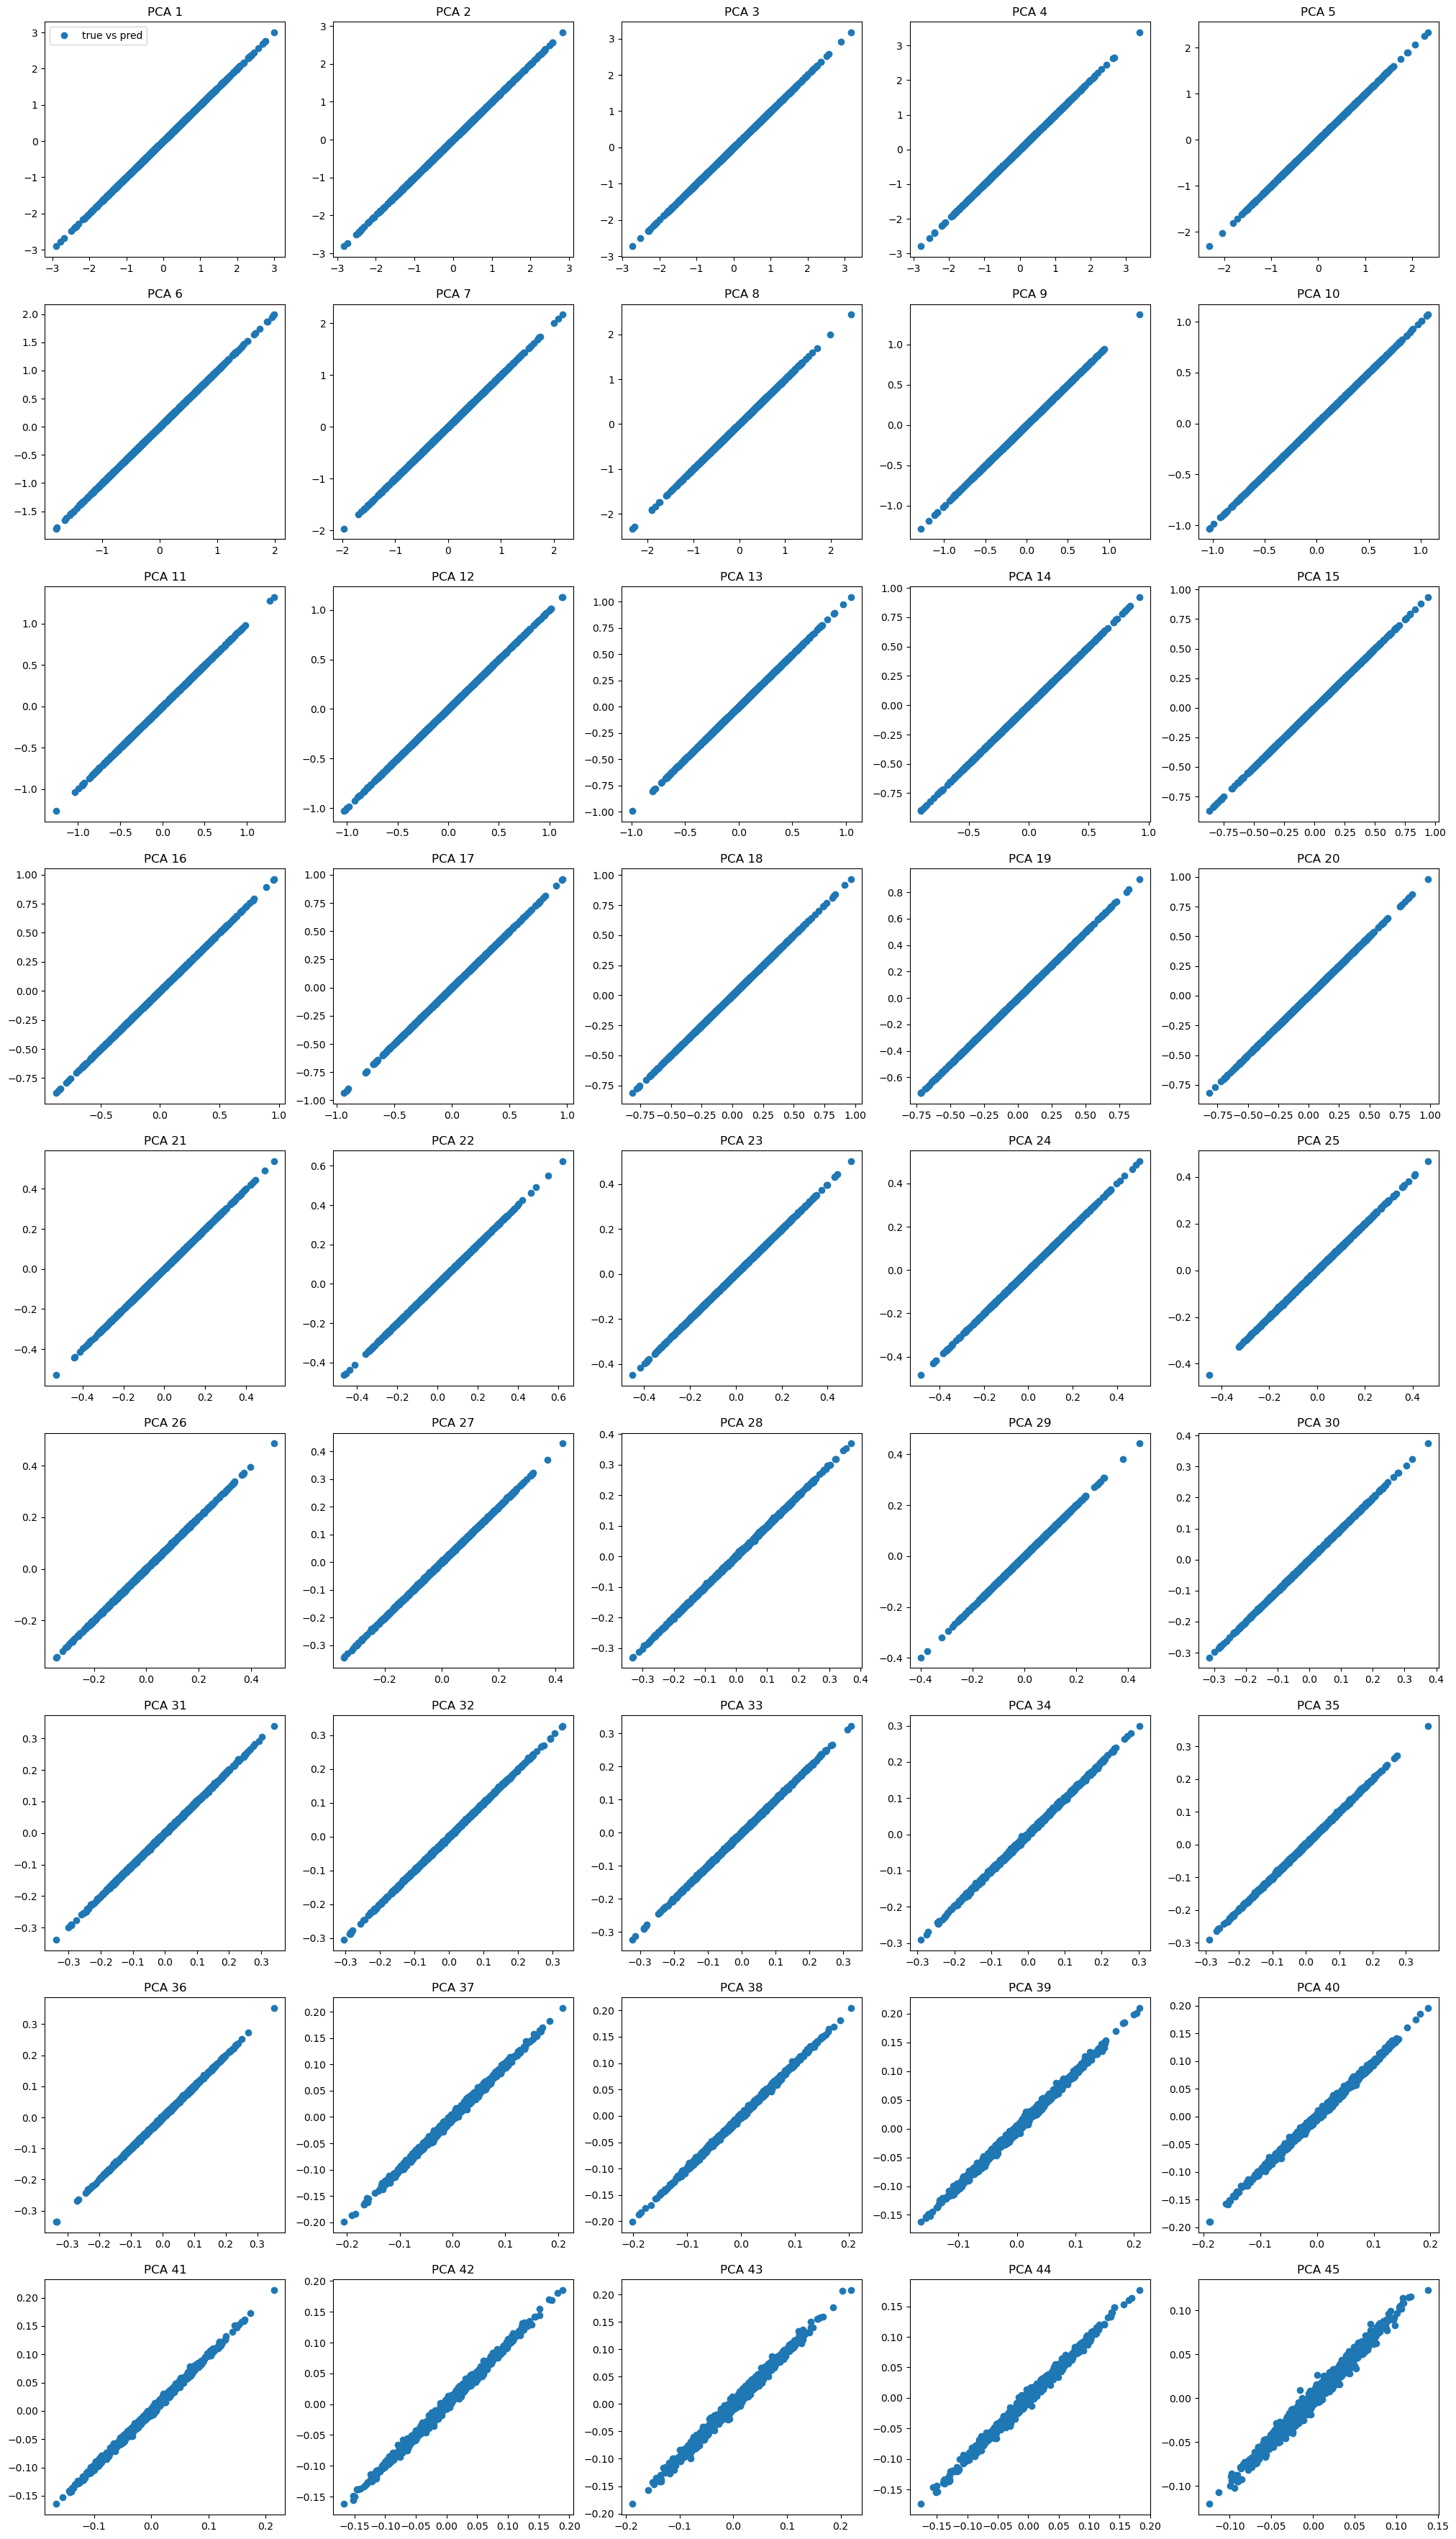

In [105]:
x_train_pca = model.x_test_pca
y_train_pca = model.y_pca.transform(y_train)

fig, ax = plt.subplots(9, 5, figsize=(25, 45))
ax = ax.flatten()

print(train_samples.shape)

for i in range(m):
    # ax[i].plot(x_train_pca[:, i], y_train_pca[:, i], 'o', label = 'true')
    # ax[i].plot(x_train_pca[:, i][np.argsort(x_train_pca[:, i])], model.y_pred_pca[:, 0, i][np.argsort(x_train_pca[:, i])], '-', label = 'pred', lw = 4)
    # for j in range(n_samples):
    #     train_samples_pca_j = train_samples[:, :, j]
    #     train_samples_j = model.y_pca.transform(train_samples_pca_j)
    #     ax[i].plot(x_train_pca[:, i][np.argsort(x_train_pca[:, i])], train_samples_j[:, i][np.argsort(train_samples_j[:, i])], '-', label = f'sample {j+1}')
    ax[i].plot(y_train_pca[:, i], model.y_pred_pca[:, 0, i], 'o', label = 'true vs pred')
    ax[i].set_title(f'PCA {i+1}')
ax[0].legend()
plt.show()

In [106]:
index_to_plot = 127

y_lims = np.array([min(y_test[index_to_plot, :].min(), y_pred_train[index_to_plot, :].min()), max(y_test[index_to_plot, :].max(), y_pred_train[index_to_plot, :].max())])

fig, ax = plt.subplots(3, 3, figsize = (15, 15))
ax = ax.flatten()
im0 = ax[0].imshow(x_train[index_to_plot, :].reshape(64, 64), origin='lower', extent=[0, 2*np.pi, 0, 2*np.pi])
ax[0].set_title("x_train")
im1 = ax[1].imshow(y_train[index_to_plot, :].reshape(64, 64), origin='lower', extent=[0, 2*np.pi, 0, 2*np.pi], norm=Normalize(vmin=y_lims[0], vmax=y_lims[1]))
ax[1].set_title("y_train")
im2 = ax[2].imshow(y_pred_train[index_to_plot, :].reshape(64, 64), origin='lower', extent=[0, 2*np.pi, 0, 2*np.pi], norm=Normalize(vmin=y_lims[0], vmax=y_lims[1]))
ax[2].set_title("y_pred_train")
for i in range(6):
    imi = ax[i+3].imshow(train_samples[index_to_plot, :, i].reshape(64, 64), origin='lower', extent=[0, 2*np.pi, 0, 2*np.pi], norm=Normalize(vmin=y_lims[0], vmax=y_lims[1]))
    ax[i+3].set_title(f"sample {i+1}")
    
            # ax[i].legend()
plt.show()

# testing

In [107]:
n_samples = 100

y_pred_test, test_samples = model.predict(x_test, n_samples = n_samples)

relative_L2 = np.linalg.norm(y_pred_test - y_test, axis = -1)/np.linalg.norm(y_test, axis = -1)

print(f'median relative L2: {np.median(relative_L2)}')
print(f'mean relative L2: {np.mean(relative_L2)}')

100%|██████████| 45/45 [01:28<00:00,  1.97s/it]


median relative L2: 0.07394598451808608
mean relative L2: 0.07595550277338123


(1000, 4096, 6)


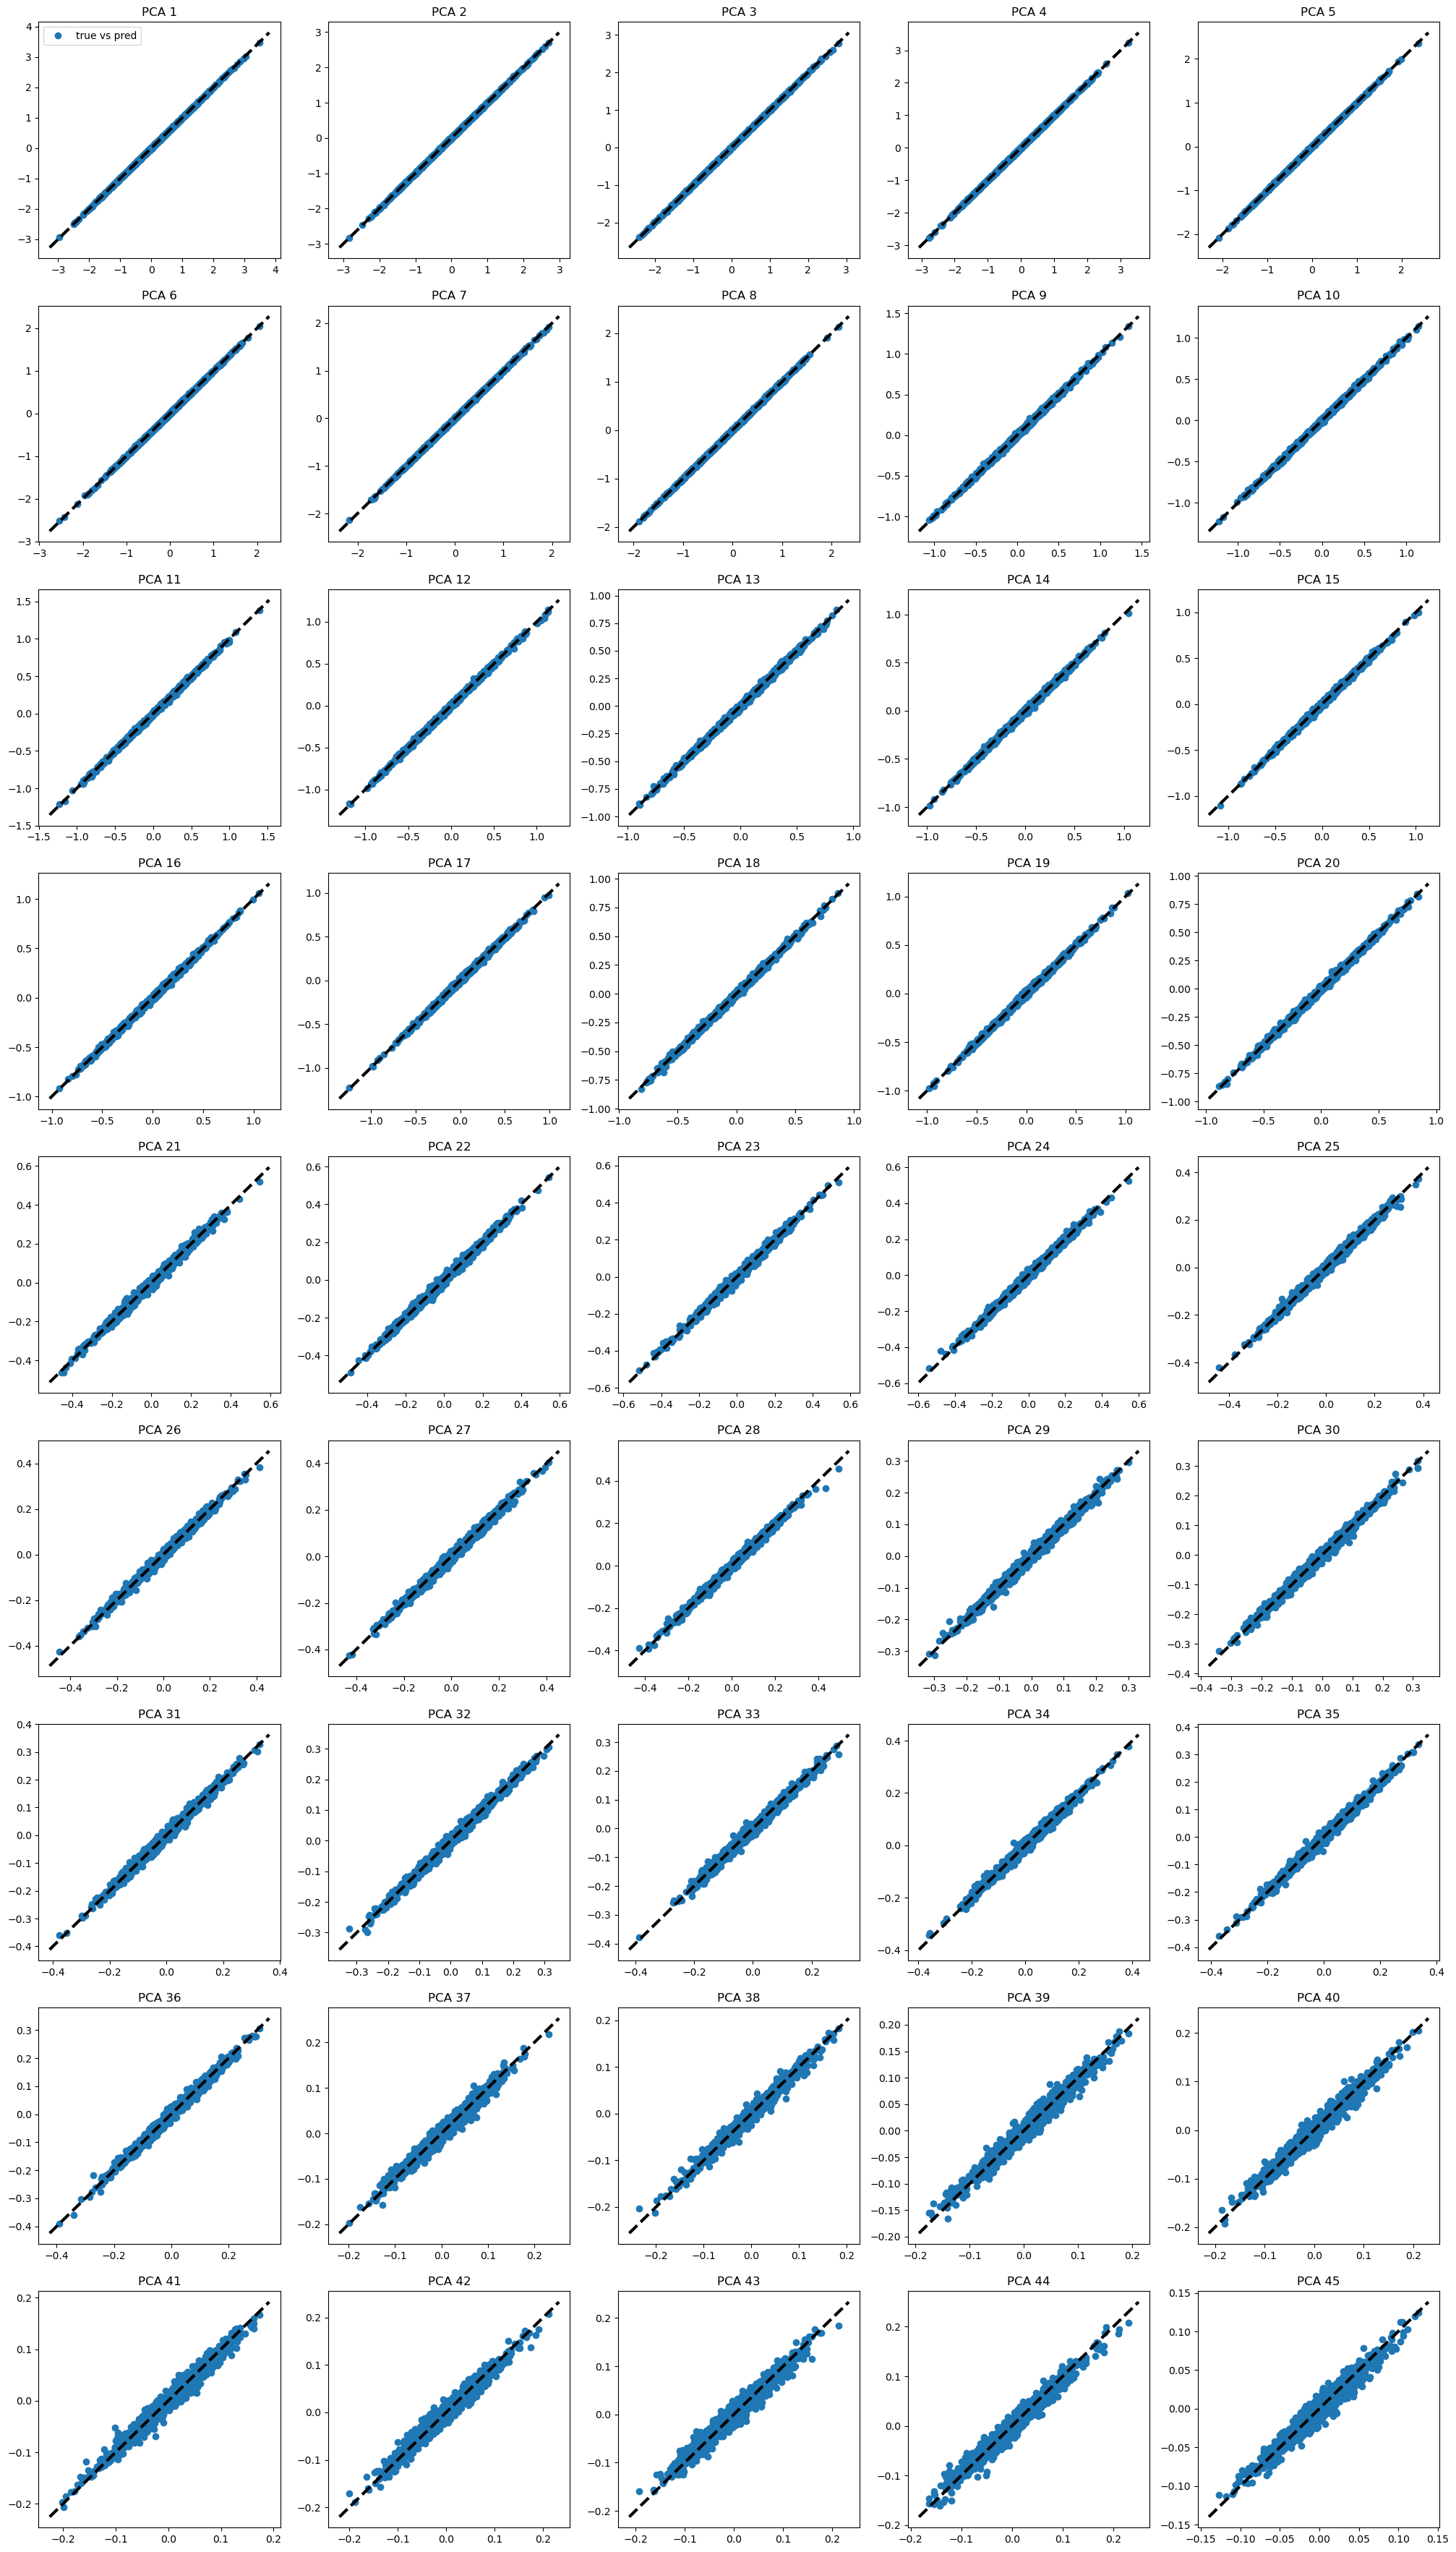

In [108]:
x_test_pca = model.x_test_pca
y_test_pca = model.y_pca.transform(y_test)

fig, ax = plt.subplots(9, 5, figsize=(25, 45))
ax = ax.flatten()

print(train_samples.shape)

for i in range(m):
    # ax[i].plot(x_train_pca[:, i], y_train_pca[:, i], 'o', label = 'true')
    # ax[i].plot(x_train_pca[:, i][np.argsort(x_train_pca[:, i])], model.y_pred_pca[:, 0, i][np.argsort(x_train_pca[:, i])], '-', label = 'pred', lw = 4)
    # for j in range(n_samples):
    #     train_samples_pca_j = train_samples[:, :, j]
    #     train_samples_j = model.y_pca.transform(train_samples_pca_j)
    #     ax[i].plot(x_train_pca[:, i][np.argsort(x_train_pca[:, i])], train_samples_j[:, i][np.argsort(train_samples_j[:, i])], '-', label = f'sample {j+1}')
    ax[i].plot(y_test_pca[:, i], model.y_pred_pca[:, 0, i], 'o', label = 'true vs pred')
    xlim = ax[i].get_xlim()
    ylim = ax[i].get_ylim()

    min_val = min(xlim[0], ylim[0])
    max_val = max(xlim[1], ylim[1])

    ax[i].plot([min_val, max_val], [min_val, max_val], 'k--', lw=3)
    ax[i].set_title(f'PCA {i+1}')
ax[0].legend()
plt.show()

In [109]:
index_to_plot = 125

y_lims = np.array([min(y_test[index_to_plot, :].min(), y_pred_test[index_to_plot, :].min()), max(y_test[index_to_plot, :].max(), y_pred_test[index_to_plot, :].max())])

fig, ax = plt.subplots(3, 3, figsize = (15, 15))
ax = ax.flatten()
im0 = ax[0].imshow(x_test[index_to_plot, :].reshape(64, 64), origin='lower', extent=[0, 2*np.pi, 0, 2*np.pi])
ax[0].set_title("x_test")
im1 = ax[1].imshow(y_test[index_to_plot, :].reshape(64, 64), origin='lower', extent=[0, 2*np.pi, 0, 2*np.pi], norm=Normalize(vmin=y_lims[0], vmax=y_lims[1]))
ax[1].set_title("y_test")
im2 = ax[2].imshow(y_pred_test[index_to_plot, :].reshape(64, 64), origin='lower', extent=[0, 2*np.pi, 0, 2*np.pi], norm=Normalize(vmin=y_lims[0], vmax=y_lims[1]))
ax[2].set_title("y_pred_test")
for i in range(6):
    imi = ax[i+3].imshow(test_samples[index_to_plot, :, i].reshape(64, 64), origin='lower', extent=[0, 2*np.pi, 0, 2*np.pi], norm=Normalize(vmin=y_lims[0], vmax=y_lims[1]))
    ax[i+3].set_title(f"sample {i+1}")
    
            # ax[i].legend()
plt.show()

## analyse uncertainty

In [110]:
print(test_samples.shape)

test_samples_mean = np.mean(test_samples, axis = 2)
test_samples_std = np.std(test_samples, axis = 2)

(1000, 4096, 100)


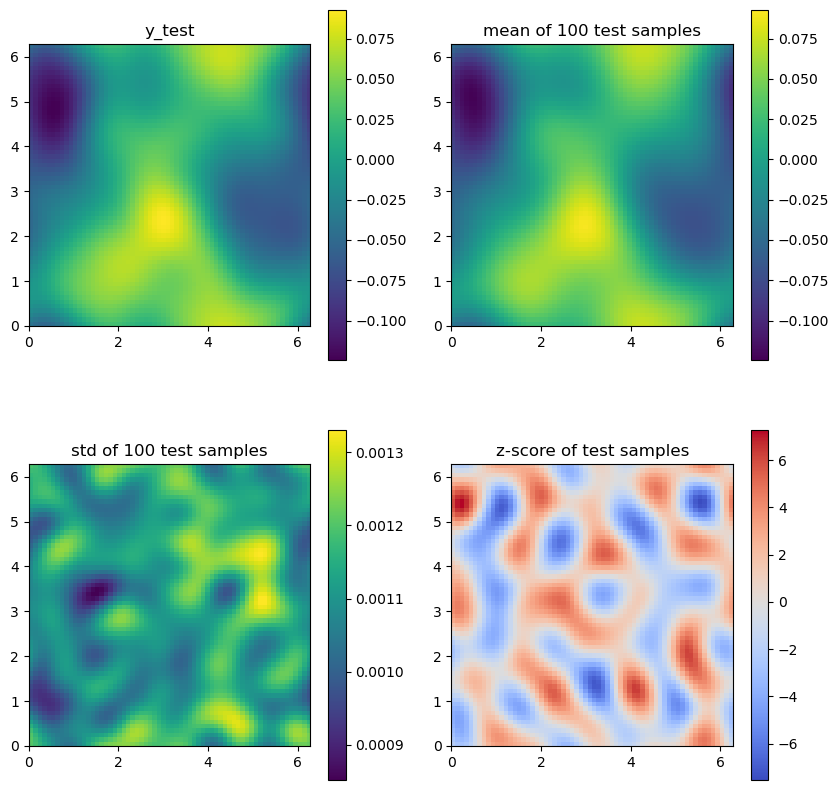

In [111]:
index_to_plot = 126

y_lims = np.array([min(y_test[index_to_plot, :].min(), test_samples_mean[index_to_plot, :].min()), max(y_test[index_to_plot, :].max(), test_samples_mean[index_to_plot, :].max())])

fig, ax = plt.subplots(2, 2, figsize = (10, 10))
ax = ax.flatten()

im0 = ax[0].imshow(y_test[index_to_plot, :].reshape(64, 64), origin='lower', extent=[0, 2*np.pi, 0, 2*np.pi], norm=Normalize(vmin=y_lims[0], vmax=y_lims[1]))
ax[0].set_title("y_test")
im1 = ax[1].imshow(test_samples_mean[index_to_plot, :].reshape(64, 64), origin='lower', extent=[0, 2*np.pi, 0, 2*np.pi], norm=Normalize(vmin=y_lims[0], vmax=y_lims[1]))
ax[1].set_title(f"mean of {n_samples} test samples")
im2 = ax[2].imshow(test_samples_std[index_to_plot, :].reshape(64, 64), origin='lower', extent=[0, 2*np.pi, 0, 2*np.pi])
ax[2].set_title(f"std of {n_samples} test samples")
im3 = ax[3].imshow((y_test[index_to_plot, :].reshape(64, 64) - test_samples_mean[index_to_plot, :].reshape(64, 64)) / test_samples_std[index_to_plot, :].reshape(64, 64), origin='lower', extent=[0, 2*np.pi, 0, 2*np.pi], cmap = 'coolwarm')
ax[3].set_title(f"z-score of test samples")
fig.colorbar(im0, ax=ax[0])
fig.colorbar(im1, ax=ax[1])
fig.colorbar(im2, ax=ax[2])
fig.colorbar(im3, ax=ax[3])


Linear regression baseline

1000 128
0.052013852952600935 0.057826029398991195


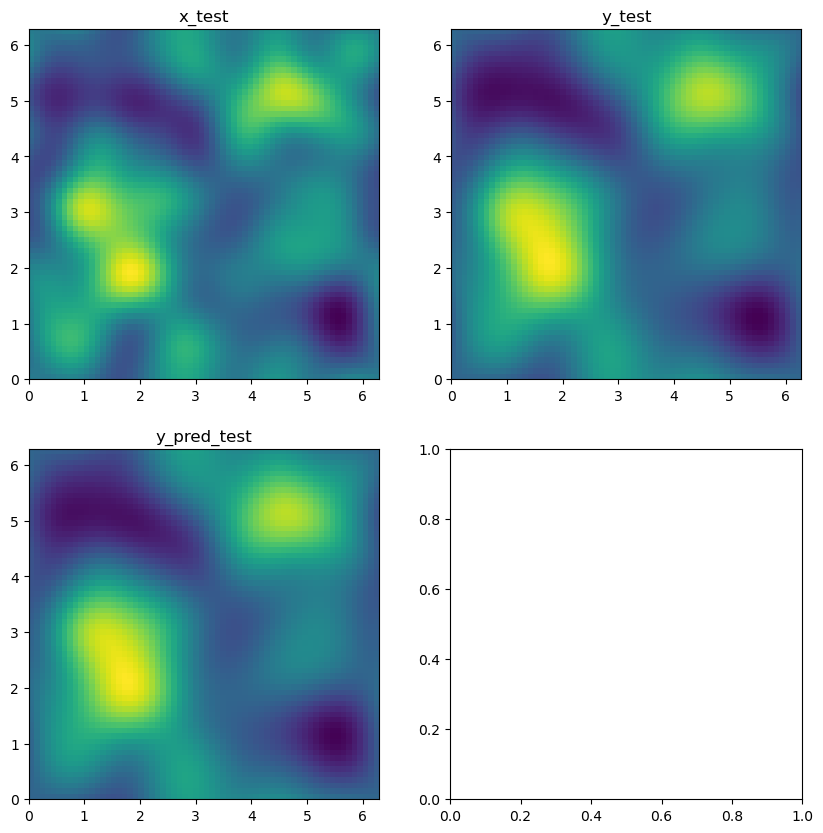

1000 256
0.05201346054841929 0.057824062070450544


1000 512
0.0520147205907808 0.05782662035921541


1000 1024
0.051470239119434616 0.0588309934177186


In [112]:
results = []
for Ntrain in [1000]:
    for N_components in [128, 256, 512, 1024]:
        print(Ntrain, N_components)
        Ytr = y_train
        Xtr = x_train
        pca = PCA(n_components=min(N_components,Ntrain))
        Xtr = pca.fit_transform(Xtr)
        reg = LinearRegression(n_jobs = -1).fit(Xtr, Ytr)
        #Ypred Ypredtr = reg.predict(Xtr)
        Ypredtr = reg.predict(Xtr)
        train_error = np.mean(np.linalg.norm(Ypredtr-Ytr, axis = 1)/np.linalg.norm(Ytr, axis = 1))
        Xtest = x_test
        Ytest = y_test
        Xtest = pca.transform(Xtest)
        Ypred = reg.predict(Xtest)
        test_error = np.mean(np.linalg.norm(Ypred-Ytest, axis = 1)/np.linalg.norm(Ytest, axis = 1))
        print(train_error, test_error)
        results.append([Ntrain, N_components, train_error, test_error])

        index_to_plot = 125

        y_lims = np.array([min(y_test[index_to_plot, :].min(), Ypred[index_to_plot, :].min()), max(y_test[index_to_plot, :].max(), Ypred[index_to_plot, :].max())])

        fig, ax = plt.subplots(2, 2, figsize = (10, 10))
        ax = ax.flatten()
        im0 = ax[0].imshow(x_test[index_to_plot, :].reshape(64, 64), origin='lower', extent=[0, 2*np.pi, 0, 2*np.pi])
        ax[0].set_title("x_test")
        im1 = ax[1].imshow(y_test[index_to_plot, :].reshape(64, 64), origin='lower', extent=[0, 2*np.pi, 0, 2*np.pi], norm=Normalize(vmin=y_lims[0], vmax=y_lims[1]))
        ax[1].set_title("y_test")
        im2 = ax[2].imshow(Ypred[index_to_plot, :].reshape(64, 64), origin='lower', extent=[0, 2*np.pi, 0, 2*np.pi], norm=Normalize(vmin=y_lims[0], vmax=y_lims[1]))
        ax[2].set_title("y_pred_test")
        plt.show()

results = np.array(results)